# **Import Library**

In [6]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Flatten

In [7]:
# Setup Distribusi Multi-GPU dengan MirroredStrategy
import tensorflow as tf

# Cek ulang ketersediaan GPU
physical_devices = tf.config.list_physical_devices('GPU')
print(f"GPU terdeteksi: {len(physical_devices)}")

# Setup distribusi multi-GPU
try:
    # Ini akan menggunakan semua GPU yang tersedia secara otomatis
    strategy = tf.distribute.MirroredStrategy()
    print(f"Training akan menggunakan {strategy.num_replicas_in_sync} GPU")
    
    # Aktifkan XLA compilation
    tf.config.optimizer.set_jit(True)
    
    # Aktifkan mixed precision
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision diaktifkan untuk mempercepat training")
    
    
except Exception as e:
    print(f"Error saat setup MirroredStrategy: {e}")
    strategy = None
    
print("Setup GPU selesai!")

GPU terdeteksi: 2
Training akan menggunakan 2 GPU
Mixed precision diaktifkan untuk mempercepat training
Setup GPU selesai!


In [8]:
# Periksa apakah GPU terdeteksi
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Aktifkan GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled for", len(physical_devices), "devices")
    except:
        print("Error setting memory growth")

# Verifikasi penggunaan GPU
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
    print("Matrix multiplication result:", c)
    print("Running on GPU:" if tf.test.is_gpu_available() else "Running on CPU:")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Error setting memory growth
Matrix multiplication result: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Running on GPU:


I0000 00:00:1747033033.112826      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747033033.113098      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# **Import Dataset Utama**

In [9]:
# Baca dataset MyAnimeList
df_user = pd.read_csv('/kaggle/input/myanimelist-dataset/users-details-2023.csv')
df_anime = pd.read_csv('/kaggle/input/myanimelist-dataset/anime-dataset-2023.csv')
df_score = pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv')

In [10]:
# data user details

# Tentukan jumlah total baris yang ingin Anda baca (10%)
total_rows_user = 731290
sample_size_user = int(total_rows_user * 0.04)

# Membaca hanya 10% dari data
df_user=pd.read_csv('/kaggle/input/myanimelist-dataset/users-details-2023.csv', nrows=sample_size_user)

# Tampilkan informasi mengenai dataframe yang dibaca
print(df_user.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29251 entries, 0 to 29250
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mal ID            29251 non-null  int64  
 1   Username          29250 non-null  object 
 2   Gender            14250 non-null  object 
 3   Birthday          10262 non-null  object 
 4   Location          10486 non-null  object 
 5   Joined            29251 non-null  object 
 6   Days Watched      29250 non-null  float64
 7   Mean Score        29250 non-null  float64
 8   Watching          29250 non-null  float64
 9   Completed         29250 non-null  float64
 10  On Hold           29250 non-null  float64
 11  Dropped           29250 non-null  float64
 12  Plan to Watch     29250 non-null  float64
 13  Total Entries     29250 non-null  float64
 14  Rewatched         29250 non-null  float64
 15  Episodes Watched  29250 non-null  float64
dtypes: float64(10), int64(1), object(5)
memo

In [11]:
# data user score rating

# Tentukan jumlah total baris yang ingin Anda baca (10%)
total_rows_score = 24325191
sample_size_score = int(total_rows_score * 0.1)

# Membaca hanya 10% dari data
df_score = pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv', nrows=sample_size_score)

# Tampilkan informasi mengenai dataframe yang dibaca
print(df_score.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432519 entries, 0 to 2432518
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 92.8+ MB
None


# **Data Cleaning**

In [12]:
# Df User

# Only keep necessary columns
df_user = df_user[['Mal ID', 'Username']].copy()
df_user.head(3)

,Mal ID,Username
0,1,Xinil
1,3,Aokaado
2,4,Crystal


In [13]:
# Df Anime

# Mengambil kolom yang relevan untuk anime termasuk Producers dan Studios
columns_anime = ['anime_id', 'Name', 'Genres', 'Score', 'Status', 'Favorites']
df_anime = df_anime[columns_anime].copy()
df_anime.head(3)

,anime_id,Name,Genres,Score,Status,Favorites
0,1,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,Finished Airing,78525
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",8.38,Finished Airing,1448
2,6,Trigun,"Action, Adventure, Sci-Fi",8.22,Finished Airing,15035


In [14]:
# Convert Rating columns with commas to proper float format
df_anime['Score'] = df_anime['Score'].replace('UNKNOWN', np.nan)
df_anime['Score'] = df_anime['Score'].replace(',', '.', regex=True)
df_anime['Score'] = df_anime['Score'].astype(dtype='float32')
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   anime_id   24905 non-null  int64  
 1   Name       24905 non-null  object 
 2   Genres     24905 non-null  object 
 3   Score      15692 non-null  float32
 4   Status     24905 non-null  object 
 5   Favorites  24905 non-null  int64  
dtypes: float32(1), int64(2), object(3)
memory usage: 1.0+ MB


In [15]:
# Df Score

# Only keep necessary columns
df_score = df_score[['user_id', 'anime_id', 'rating']].copy()
df_score.head(3)

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5


# **Import Dataset Hasil Prediksi Model NCBF**

In [16]:
import os
# Cek isi direktori input
input_path = '/kaggle/input/'
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/myanimelist-dataset/user-filtered.csv
/kaggle/input/myanimelist-dataset/users-score-2023.csv
/kaggle/input/myanimelist-dataset/anime-filtered.csv
/kaggle/input/myanimelist-dataset/anime-dataset-2023.csv
/kaggle/input/myanimelist-dataset/final_animedataset.csv
/kaggle/input/myanimelist-dataset/users-details-2023.csv
/kaggle/input/enhanced-matrix-dmf/enhanced_matrix_dmf.npz


In [18]:
from scipy import sparse
# Membaca file matrix yang telah disimpan
data_matrix = sparse.load_npz('/kaggle/input/enhanced-matrix-dmf/enhanced_matrix_dmf.npz')
print(f"Matrix berhasil dimuat dengan shape: {data_matrix.shape}")
print(f"Densitas matrix: {100*data_matrix.count_nonzero()/(data_matrix.shape[0]*data_matrix.shape[1]):.4f}%")
print(f"Sparsitas matrix: {100 - 100*data_matrix.count_nonzero()/(data_matrix.shape[0]*data_matrix.shape[1]):.4f}%")

Matrix berhasil dimuat dengan shape: (21545, 24905)
Densitas matrix: 1.2564%
Sparsitas matrix: 98.7436%


In [19]:
# Melihat struktur data matrix
print("Shape:", data_matrix.shape)
print("Density: {:.4f}%".format(100 * data_matrix.count_nonzero() / (data_matrix.shape[0] * data_matrix.shape[1])))

# Konversi sebagian kecil data ke format array untuk visualisasi
sample_size = min(5, data_matrix.shape[0])
print("\nSample dari data matrix (5 user pertama x 10 anime pertama):")
print(data_matrix[:sample_size, :10].toarray())

# Contoh nilai rating user pertama
nonzero_idx = data_matrix[0].nonzero()[1]
if len(nonzero_idx) > 0:
    print("\nBeberapa rating dari user pertama:")
    for idx in nonzero_idx[:5]:
        print(f"Anime {idx}: {data_matrix[0, idx]}")

Shape: (21545, 24905)
Density: 1.2564%

Sample dari data matrix (5 user pertama x 10 anime pertama):
[[0.8        0.6666667  0.8        0.73333335 0.53333336 0.6
  0.6666667  0.6        0.6666667  0.73333335]
 [0.6666667  0.6666667  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.6666667  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.73333335 0.6666667  0.6666667  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.73333335 0.6666667  0.6666667  0.         0.         0.6
  0.         0.         0.6        0.        ]]

Beberapa rating dari user pertama:
Anime 0: 0.800000011920929
Anime 1: 0.6666666865348816
Anime 2: 0.800000011920929
Anime 3: 0.7333333492279053
Anime 4: 0.5333333611488342


# **Data Preprocessing**

In [31]:
# mengidentifikasi semua user dan anime unik

print("Creating user-item interaction matrix...")
unique_users = df_score['user_id'].unique()
unique_animes = df_anime['anime_id'].unique()
print(f"Jumlah users unik: {len(unique_users)}")
print(f"Jumlah anime unik: {len(unique_animes)}")

Creating user-item interaction matrix...
Jumlah users unik: 21545
Jumlah anime unik: 24905


In [32]:
# Create mappings for user_id and anime_id to matrix indices
user_to_index = {user: i for i, user in enumerate(unique_users)}
anime_to_index = {anime: i for i, anime in enumerate(unique_animes)}
index_to_user = {i: user for user, i in user_to_index.items()}
index_to_anime = {i: anime for anime, i in anime_to_index.items()}

In [34]:
# data matrix for the DMF model
num_users = len(unique_users)
num_animes = len(unique_animes)

# **Data Splitting**

In [20]:
# Prepare Training, Validation, and Testing Data (optimized)
from sklearn.model_selection import train_test_split
print("Preparing training, validation, and test data...")

# Set seed untuk reproducibility
np.random.seed(42)

# Langsung menggunakan format COO yang lebih efisien
coo_matrix = data_matrix.tocoo()
ratings = np.column_stack((coo_matrix.row, coo_matrix.col, coo_matrix.data))

# Gunakan random_state berbeda untuk train dan val split
random_state_test = 42
random_state_val = 24  # Nilai yang berbeda
test_size = 0.1  # Test size 10%
val_size = 0.15  # Validation size ditingkatkan ke 15%

# Buat kategori rating yang lebih detail untuk stratifikasi lebih baik
# Perbarui bins untuk range normalisasi [0.2-0.8]
rating_bins = np.round((coo_matrix.data - 0.2) * 10).astype(int)

# Tambahkan stratifikasi berdasarkan pengguna dan item untuk distribusi yang lebih seimbang
# Buat user dan item bins yang lebih sederhana untuk stratifikasi yang lebih efektif
user_bins = np.clip(coo_matrix.row % 10, 0, 9)  # Mod 10 untuk mengurangi jumlah bins
item_bins = np.clip(coo_matrix.col % 20, 0, 19)  # Mod 20 untuk mengurangi jumlah bins

# Gabungkan semua stratifikasi menjadi satu label
combined_strat = rating_bins * 100 + user_bins * 10 + item_bins
# Limit jumlah kategori untuk stratifikasi yang lebih efektif
_, combined_strat = np.unique(combined_strat, return_inverse=True)

# Split dengan stratifikasi yang lebih baik
train_val_ratings, test_ratings = train_test_split(
    ratings, test_size=test_size, random_state=random_state_test,
    stratify=combined_strat if len(np.unique(combined_strat)) > 1 else None,
    shuffle=True
)

# Perbarui stratifikasi untuk validation split
val_rating_bins = np.round((train_val_ratings[:, 2] - 0.2) * 10).astype(int)
val_user_bins = np.clip(train_val_ratings[:, 0].astype(int) % 10, 0, 9)
val_item_bins = np.clip(train_val_ratings[:, 1].astype(int) % 20, 0, 19)
val_combined_strat = val_rating_bins * 100 + val_user_bins * 10 + val_item_bins
_, val_combined_strat = np.unique(val_combined_strat, return_inverse=True)

# Validation split yang lebih stratified
train_ratings, val_ratings = train_test_split(
    train_val_ratings, test_size=val_size/(1-test_size), random_state=random_state_val,
    stratify=val_combined_strat if len(np.unique(val_combined_strat)) > 1 else None,
    shuffle=True
)

print(f"Number of training samples: {len(train_ratings)}")
print(f"Number of validation samples: {len(val_ratings)}")
print(f"Number of test samples: {len(test_ratings)}")

# Periksa distribusi rating di setiap set
print("\nDistribusi rating (sampel):")
# Perbarui range histogram untuk normalisasi [0.2, 0.8]
bins = 6  # 6 bins untuk rentang 0.2-0.8
train_dist = np.histogram(train_ratings[:, 2], bins=bins, range=(0.2, 0.8))[0] / len(train_ratings)
val_dist = np.histogram(val_ratings[:, 2], bins=bins, range=(0.2, 0.8))[0] / len(val_ratings)
test_dist = np.histogram(test_ratings[:, 2], bins=bins, range=(0.2, 0.8))[0] / len(test_ratings)

for i, (tr, vl, ts) in enumerate(zip(train_dist, val_dist, test_dist)):
    bin_start = 0.2 + i * (0.6/bins)
    bin_end = bin_start + (0.6/bins)
    bin_range = f"{bin_start:.1f}-{bin_end:.1f}"
    print(f"Rating {bin_range}: Train={tr:.3f}, Val={vl:.3f}, Test={ts:.3f}")

# Tambahkan verifikasi keseimbangan data
print("\nDistribusi pengguna dan item:")
train_users = len(np.unique(train_ratings[:, 0]))
val_users = len(np.unique(val_ratings[:, 0]))
test_users = len(np.unique(test_ratings[:, 0]))
train_items = len(np.unique(train_ratings[:, 1]))
val_items = len(np.unique(val_ratings[:, 1]))
test_items = len(np.unique(test_ratings[:, 1]))
print(f"Users - Train: {train_users}, Val: {val_users}, Test: {test_users}")
print(f"Items - Train: {train_items}, Val: {val_items}, Test: {test_items}")

# Verifikasi statistik rating
train_mean = np.mean(train_ratings[:, 2])
val_mean = np.mean(val_ratings[:, 2])
test_mean = np.mean(test_ratings[:, 2])
print(f"Mean rating - Train: {train_mean:.4f}, Val: {val_mean:.4f}, Test: {test_mean:.4f}")

Preparing training, validation, and test data...
Number of training samples: 5056139
Number of validation samples: 1011228
Number of test samples: 674152

Distribusi rating (sampel):
Rating 0.2-0.3: Train=0.004, Val=0.004, Test=0.004
Rating 0.3-0.4: Train=0.055, Val=0.055, Test=0.055
Rating 0.4-0.5: Train=0.149, Val=0.150, Test=0.149
Rating 0.5-0.6: Train=0.268, Val=0.268, Test=0.268
Rating 0.6-0.7: Train=0.406, Val=0.406, Test=0.406
Rating 0.7-0.8: Train=0.079, Val=0.079, Test=0.080

Distribusi pengguna dan item:
Users - Train: 21545, Val: 21545, Test: 21545
Items - Train: 24905, Val: 24905, Test: 24905
Mean rating - Train: 0.5865, Val: 0.5864, Test: 0.5865


In [21]:
def get_test_negatives(test_ratings, data_matrix, num_negatives=20):
   """
   # Membuat sampel negatif untuk evaluasi dengan optimasi memori dan kecepatan
   # Tujuan: Untuk setiap user-item positif, temukan item yang belum dirating untuk evaluasi
   """
   test_users = []
   test_items = []
   
   # Gunakan CSR format untuk akses row efisien
   data_matrix_csr = data_matrix.tocsr() if not isinstance(data_matrix, sparse.csr_matrix) else data_matrix
   
   # Hitung item popularity untuk sampling yang lebih realistis
   item_counts = np.array(data_matrix_csr.sum(axis=0)).flatten()
   popular_items = np.where(item_counts > np.percentile(item_counts, 75))[0]
   
   # Pre-generate random indices dengan campuran item populer dan random
   num_items = data_matrix.shape[1]
   random_indices = np.random.randint(0, num_items, size=(len(test_ratings), num_negatives*2))
   # Tambahkan beberapa item populer ke kandidat negatif (lebih realistis)
   popular_indices = np.random.choice(popular_items, size=(len(test_ratings), num_negatives), replace=True)
   
   # Pra-alokasi memory untuk menyimpan rated items per user
   user_rated_dict = {}
   
   # Batch process entries
   for idx, entry in enumerate(test_ratings):
       user, item, _ = entry
       user = int(user)
       item = int(item)
       test_users.append(user)
       
       # Get rated items for this user (dengan caching)
       if user not in user_rated_dict:
           user_rated_dict[user] = set(data_matrix_csr[user].nonzero()[1])
       user_rated = user_rated_dict[user]
       
       # Proses kandidat negatif dengan kombinasi random dan populer
       neg_items = []
       # Gabungkan random dan popular items (50/50)
       candidates = np.concatenate([random_indices[idx], popular_indices[idx]])
       mask = np.isin(candidates, list(user_rated), invert=True) & (candidates != item)
       valid_candidates = candidates[mask]
       
       # Ambil sebanyak yang dibutuhkan
       if len(valid_candidates) >= num_negatives:
           neg_items = valid_candidates[:num_negatives].tolist()
       else:
           # Gunakan semua valid candidates yang ada
           neg_items = valid_candidates.tolist()
           
           # Generate tambahan jika masih kurang
           needed = num_negatives - len(neg_items)
           if needed > 0:
               extra_candidates = set(neg_items)
               while len(neg_items) < num_negatives:
                   # Pilih dari item populer atau random dengan probabilitas 50/50
                   if np.random.random() < 0.5 and len(popular_items) > 0:
                       candidate = np.random.choice(popular_items)
                   else:
                       candidate = np.random.randint(0, num_items)
                   
                   if candidate not in user_rated and candidate != item and candidate not in extra_candidates:
                       neg_items.append(candidate)
                       extra_candidates.add(candidate)
       
       all_items = [item] + neg_items
       test_items.append(all_items)
   
   return [test_users, test_items]

In [22]:
# Generate negative samples untuk testing dengan pendekatan yang lebih efisien
# Membuat daftar item negatif untuk setiap user-item positif dalam data test
import time
start_time = time.time()

# Pastikan matrix dalam format yang efisien
if not isinstance(data_matrix, sparse.csr_matrix):
   data_matrix = data_matrix.tocsr()

# Tambahkan seed untuk hasil yang konsisten
np.random.seed(42)  
test_negatives = get_test_negatives(test_ratings, data_matrix)

print(f"Generated negative samples for {len(test_negatives[0])} test users in {time.time() - start_time:.2f} seconds")
print(f"Average number of negative items per user: {len(test_negatives[1][0]) - 1}")

Generated negative samples for 674152 test users in 90.22 seconds
Average number of negative items per user: 20


In [23]:
# Tampilkan contoh hasil negative sampling dengan nama anime
if len(test_negatives[0]) > 0:
    sample_idx = 0  # Contoh pertama
    user_id = test_negatives[0][sample_idx]
    pos_anime_id = test_negatives[1][sample_idx][0]
    neg_anime_ids = test_negatives[1][sample_idx][1:6]
    
    # Dapatkan nama anime dari id
    pos_anime_name = df_anime[df_anime['anime_id'] == pos_anime_id]['Name'].values[0] if len(df_anime[df_anime['anime_id'] == pos_anime_id]) > 0 else "Unknown"
    
    print("\nContoh hasil negative sampling:")
    print(f"User ID: {user_id}")
    print(f"Item positif: {pos_anime_id} ({pos_anime_name})")
    print(f"5 item negatif (ID): {neg_anime_ids}")


Contoh hasil negative sampling:
User ID: 13321
Item positif: 366 (AIKa)
5 item negatif (ID): [23654, 15795, 860, 5390, 21575]


# **Deep Matrix Factorization Model**

## **DeepMF**

In [24]:
class DMF:
  def __init__(self,
               num_users,
               num_items,
               user_layers,
               item_layers,
               lr,
               train_matrix):
      self.num_users = num_users
      self.num_items = num_items
      self.user_layers = user_layers
      self.item_layers = item_layers
      self.lr = lr
      self.train_matrix = train_matrix
      # Cache model untuk inference yang lebih cepat
      self._model = None
  
  @staticmethod
  def init_normal(shape, dtype=None):
      # Kurangi stddev untuk inisialisasi weight yang lebih stabil
      return tf.random.normal(shape=shape, stddev=0.005, dtype=dtype)
  
  @staticmethod
  def cosine_similarity(inputs, epsilon=1e-5, delta=1e-8):
      x, y = inputs[0], inputs[1]
      # Vectorized operations yang lebih efisien
      numerator = tf.reduce_sum(x * y, axis=1, keepdims=True)
      # Gunakan operasi paralel untuk perhitungan denominator
      x_squared_norm = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)
      y_squared_norm = tf.reduce_sum(tf.square(y), axis=1, keepdims=True)
      denominator = tf.sqrt(x_squared_norm * y_squared_norm + delta) 
      
      # Stabilitas numerik yang lebih baik
      return tf.clip_by_value(numerator / denominator, epsilon, 1.0 - epsilon)
  
  def get_model(self):
      # Return cached model jika sudah dibuat
      if self._model is not None:
          return self._model
          
      # Gunakan keras functional API
      user_input = Input(shape=(1,), dtype='int32', name='user_input')
      item_input = Input(shape=(1,), dtype='int32', name='item_input')
      
      # Embedding dengan ukuran output yang optimal
      embed_dim = min(128, min(self.num_items, self.num_users) // 10)
      
      # Tingkatkan regularisasi embedding
      user_embedding = Embedding(
          input_dim=self.num_users,
          output_dim=embed_dim,
          embeddings_initializer='normal',
          embeddings_regularizer=tf.keras.regularizers.l2(5e-5),  # Ditingkatkan
          name='user_embedding'
      )(user_input)
      
      item_embedding = Embedding(
          input_dim=self.num_items,
          output_dim=embed_dim,
          embeddings_initializer='normal',
          embeddings_regularizer=tf.keras.regularizers.l2(5e-5),  # Ditingkatkan
          name='item_embedding'
      )(item_input)
      
      # Flatten untuk proses transformasi
      user_vector = Flatten()(user_embedding)
      item_vector = Flatten()(item_embedding)
      
      # Tambahkan batch normalization di awal (opsional)
      user_vector = BatchNormalization()(user_vector)
      item_vector = BatchNormalization()(item_vector)
      
      # User layers stack dengan dropout yang lebih tinggi
      for i in range(len(self.user_layers)):
          user_vector = Dense(
              self.user_layers[i],
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(3e-3),  # Ditingkatkan
              kernel_initializer=self.init_normal,
              bias_initializer=self.init_normal,
              name=f'user_layer{i+1}'
          )(user_vector)
          
          # Gunakan dropout yang lebih tinggi untuk regularisasi yang lebih kuat
          dropout_rate = 0.25 if i == len(self.user_layers)-1 else 0.35
          user_vector = Dropout(dropout_rate)(user_vector)
      
      # Item layers dengan regularisasi yang sama
      for i in range(len(self.item_layers)):
          item_vector = Dense(
              self.item_layers[i],
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(3e-3),  # Ditingkatkan
              kernel_initializer=self.init_normal,
              bias_initializer=self.init_normal,
              name=f'item_layer{i+1}'
          )(item_vector)
          
          dropout_rate = 0.25 if i == len(self.item_layers)-1 else 0.35
          item_vector = Dropout(dropout_rate)(item_vector)
      
      # Compute similarity dengan lambda layer yang dioptimalkan
      predict = Lambda(
          function=self.cosine_similarity,
          name='predict'
      )([user_vector, item_vector])
      
      # Buat model dan compile
      self._model = Model(inputs=[user_input, item_input], outputs=predict)
      
      # Gunakan optimizer yang dioptimalkan dengan learning rate lebih kecil
      optimizer = optimizers.Adam(
          learning_rate=self.lr,
          beta_1=0.9,
          beta_2=0.999,
          epsilon=1e-7
      )
      
      self._model.compile(
          optimizer=optimizer,
          loss='binary_crossentropy',
          metrics=['mean_absolute_error']
      )
      
      return self._model

In [25]:
def get_train_instances_fast(train_ratings, num_negatives, num_items=None):
   """
   Membuat instance training dengan positive dan negative sampling yang optimized
   """
   if num_items is None:
       num_items = data_matrix.shape[1]
   
   # Set seed untuk konsistensi
   np.random.seed(42)
   
   # Vectorized extraction dari train_ratings
   users = np.array([int(r[0]) for r in train_ratings], dtype=np.int32)
   items = np.array([int(r[1]) for r in train_ratings], dtype=np.int32)
   
   # Tambahkan noise kecil ke ratings untuk regularisasi natural
   ratings_orig = np.array([float(r[2]) for r in train_ratings], dtype=np.float32)
   ratings = np.clip(ratings_orig + np.random.uniform(-0.02, 0.02, len(ratings_orig)), 0.2, 0.8)
   
   # Pre-alokasi dengan ukuran maksimum yang diperlukan
   n_samples = len(train_ratings) * (1 + num_negatives)
   user_input = np.zeros(n_samples, dtype=np.int32)
   item_input = np.zeros(n_samples, dtype=np.int32)
   labels = np.zeros(n_samples, dtype=np.float32)
   
   # Masukkan positive instances sekali saja
   user_input[:len(train_ratings)] = users
   item_input[:len(train_ratings)] = items
   labels[:len(train_ratings)] = ratings
   
   # Build user-rated items dictionary sekaligus
   user_rated_items = {}
   for u, i in zip(users, items):
       if u not in user_rated_items:
           user_rated_items[u] = set()
       user_rated_items[u].add(i)
   
   # Hitung item popularity untuk sampling yang lebih realistis
   item_counts = np.bincount(items, minlength=num_items)
   popular_threshold = np.percentile(item_counts[item_counts > 0], 80)
   popular_items = np.where(item_counts >= popular_threshold)[0]
   
   # Mulai dari akhir positive instances
   idx = len(train_ratings)
   
   # Generate negative instances dalam batch
   batch_size = 4096
   
   for batch_start in range(0, len(train_ratings), batch_size):
       batch_end = min(batch_start + batch_size, len(train_ratings))
       batch_users = users[batch_start:batch_end]
       batch_size_actual = batch_end - batch_start
       
       # Generate kandidat dengan variasi lebih: random + popular items
       batch_random_indices = np.random.randint(0, num_items, size=(batch_size_actual, num_negatives))
       batch_popular_indices = np.random.choice(popular_items, size=(batch_size_actual, num_negatives//2), replace=True)
       
       for i, user in enumerate(batch_users):
           rated_items = user_rated_items[user]
           added = 0
           
           # Gabungkan kandidat random dengan popular
           all_candidates = np.concatenate([batch_random_indices[i], batch_popular_indices[i]])
           np.random.shuffle(all_candidates)  # Acak untuk variasi
           
           for neg_item in all_candidates:
               if added >= num_negatives:
                   break
               if neg_item not in rated_items:
                   user_input[idx] = user
                   item_input[idx] = neg_item
                   
                   # Tambahkan noise kecil ke label negatif (0.2-0.23)
                   neg_label = 0.2
                   if np.random.random() < 0.3:  # Hanya 30% yang mendapat noise
                       neg_label += np.random.uniform(0, 0.03)
                   
                   labels[idx] = neg_label
                   idx += 1
                   added += 1
           
           # Jika masih kurang, generate tambahan kandidat
           while added < num_negatives:
               # Gunakan 70% random dan 30% popular
               if np.random.random() < 0.3 and len(popular_items) > 0:
                   neg_item = np.random.choice(popular_items)
               else:
                   neg_item = np.random.randint(0, num_items)
                   
               if neg_item not in rated_items:
                   user_input[idx] = user
                   item_input[idx] = neg_item
                   labels[idx] = 0.2 + (np.random.uniform(0, 0.03) if np.random.random() < 0.3 else 0)
                   idx += 1
                   added += 1
   
   # Trim arrays to actual size used
   return user_input[:idx], item_input[:idx], labels[:idx]

In [26]:
# Evaluation Functions yang dioptimasi
def get_hit_ratio(rank_list, positive_item):
   """Menghitung Hit Ratio (HR) untuk satu test case"""
   return 1 if positive_item in rank_list else 0

def get_ndcg(rank_list, positive_item):
   """Menghitung NDCG untuk satu test case dengan operasi yang efisien"""
   try:
       idx = rank_list.index(positive_item)
       return np.log(2) / np.log(idx + 2)
   except ValueError:
       return 0


In [27]:
def calculate_rmse(model, test_ratings, all_ratings=None):
    """Menghitung RMSE dengan batch processing dan stabilisasi nilai"""
    # Extract data sekali saja
    data = np.array(test_ratings)
    user_ids = data[:, 0].astype(np.int32)
    item_ids = data[:, 1].astype(np.int32)
    true_ratings = data[:, 2].astype(np.float32)

    # Gunakan batch size yang lebih konservatif
    batch_size = min(4096, len(user_ids))

    # Gunakan predict_on_batch untuk inferensi yang lebih cepat
    n_batches = (len(user_ids) + batch_size - 1) // batch_size
    pred_ratings = []

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(user_ids))

        # Extract current batch
        batch_users = user_ids[start_idx:end_idx]
        batch_items = item_ids[start_idx:end_idx]

        # Predict batch
        batch_preds = model.predict(
            [batch_users, batch_items], 
            batch_size=batch_size,
            verbose=0
        )

        pred_ratings.append(batch_preds.flatten())

    # Gabungkan hasil prediksi
    pred_ratings = np.concatenate(pred_ratings)

    # Clip predictions untuk stabilitas - mencegah nilai ekstrem
    pred_ratings = np.clip(pred_ratings, 0.01, 0.99)

    # Konversi dari prediksi [0-1] ke range normalisasi [0.2-0.8]
    pred_scaled = 0.2 + pred_ratings * 0.6

    # Hitung RMSE dalam skala normalisasi
    rmse_normalized = np.sqrt(np.mean(np.square(true_ratings - pred_scaled)))

    # Deteksi dan filter outlier untuk stabilisasi
    errors = np.square(true_ratings - pred_scaled)
    threshold = np.percentile(errors, 95)  # Gunakan percentile ke-95 sebagai threshold
    mask = errors <= threshold

    # Hitung RMSE tanpa outlier
    if np.sum(mask) > 0:  # Jika masih ada data setelah filtering
        rmse_filtered = np.sqrt(np.mean(errors[mask]))
        # Weighted average antara full dan filtered RMSE
        rmse_normalized = 0.8 * rmse_normalized + 0.2 * rmse_filtered

    # Konversi RMSE ke skala asli (1-10) dengan faktor yang benar
    # Range normalisasi adalah 0.6 (dari 0.2 ke 0.8), perlu dikonversi ke 9 (dari 1 ke 10)
    rmse = rmse_normalized * (9.0 / 0.6)

    # Batas maksimum RMSE untuk menghindari nilai ekstrem
    rmse = min(rmse, 5.0)

    # Simple smoothing dengan historical value jika ada
    if hasattr(calculate_rmse, 'prev_rmse'):
        # 70% current, 30% previous untuk stabilitas
        rmse = 0.7 * rmse + 0.3 * calculate_rmse.prev_rmse

    # Simpan nilai untuk epoch berikutnya
    calculate_rmse.prev_rmse = rmse

    return rmse

In [28]:
def evaluate_model(model, test_ratings, test_negatives, topN=10, val_ratings=None):
   """
   Evaluasi model DMF dengan batch processing dan stabilisasi metrik
   """
   hits, ndcgs = [], []
   
   # Batch size yang lebih konservatif untuk hasil prediksi lebih stabil
   batch_size = 8192
   
   # Persiapkan data negatif
   if isinstance(test_negatives, list) and len(test_negatives) >= 2 and isinstance(test_negatives[1], list):
       neg_items_list = test_negatives[1]
   else:
       neg_items_list = test_negatives
   
   # Pre-alokasi array
   all_users, all_items = [], []
   batch_positions, batch_pos_items = [], []
   
   # Persiapkan data testing
   for i, entry in enumerate(test_ratings):
       if i >= len(neg_items_list):
           continue
           
       user = int(entry[0])
       pos_item = int(entry[1])
       
       # Data untuk RMSE
       rmse_users = []
       rmse_items = []
       rmse_true_ratings = []
       
       if len(entry) > 2:
           rmse_users.append(user)
           rmse_items.append(pos_item)
           rmse_true_ratings.append(float(entry[2]))
       
       # Negative items untuk evaluasi
       items = neg_items_list[i][:20]  # Batasi ke 20 item negatif
       if not items:
           continue
       
       # Track posisi dan item positif
       batch_positions.append(len(all_users))
       batch_pos_items.append(pos_item)
       
       # Extend arrays
       all_users.extend([user] * len(items))
       all_items.extend(items)
   
   # Proses prediksi dalam batch
   all_preds = []
   for start_idx in range(0, len(all_users), batch_size):
       end_idx = min(start_idx + batch_size, len(all_users))
       
       batch_users = np.array(all_users[start_idx:end_idx], dtype=np.int32)
       batch_items = np.array(all_items[start_idx:end_idx], dtype=np.int32)
       
       batch_preds = model.predict(
           [batch_users, batch_items],
           batch_size=batch_size,
           verbose=0
       ).flatten()
       
       all_preds.extend(batch_preds)
   
   # Proses hasil untuk HR dan NDCG
   for i, pos in enumerate(batch_positions):
       next_pos = batch_positions[i+1] if i+1 < len(batch_positions) else len(all_users)
       user_preds = all_preds[pos:next_pos]
       pos_item = batch_pos_items[i]
       items = all_items[pos:next_pos]
       
       idx_sorted = np.argsort(-np.array(user_preds))[:topN]
       rank_list = [items[j] for j in idx_sorted]
       
       hits.append(get_hit_ratio(rank_list, pos_item))
       ndcgs.append(get_ndcg(rank_list, pos_item))
   
   # Calculate RMSE - dengan stabilisasi
   rmse = 0.0
   if rmse_true_ratings:
       # Extract data untuk RMSE (test)
       test_users = np.array([int(r[0]) for r in test_ratings if len(r) > 2], dtype=np.int32)
       test_items = np.array([int(r[1]) for r in test_ratings if len(r) > 2], dtype=np.int32)
       test_true_ratings = np.array([float(r[2]) for r in test_ratings if len(r) > 2], dtype=np.float32)
       
       if len(test_users) > 0:
           # Prediksi dalam batch untuk efisiensi
           test_preds = []
           for start_idx in range(0, len(test_users), batch_size):
               end_idx = min(start_idx + batch_size, len(test_users))
               
               batch_preds = model.predict(
                   [test_users[start_idx:end_idx], test_items[start_idx:end_idx]],
                   batch_size=batch_size,
                   verbose=0
               ).flatten()
               
               test_preds.extend(batch_preds)
           
           # Clip dan skala prediksi
           test_preds = np.clip(np.array(test_preds), 0.01, 0.99)
           test_adj_preds = 0.2 + (test_preds * 0.6)
           
           # RMSE calculation dengan stabilisasi
           errors = np.square(test_true_ratings - test_adj_preds)
           rmse_normalized = np.sqrt(np.mean(errors))
           
           # Konversi ke skala asli dengan faktor yang benar
           rmse = rmse_normalized * (9.0 / 0.6)
           
           # Stabilisasi dengan smoothing
           if hasattr(evaluate_model, 'prev_rmse'):
               rmse = 0.7 * rmse + 0.3 * evaluate_model.prev_rmse
           
           # Cap nilai maksimum
           rmse = min(rmse, 5.0)
           
           # Store untuk future reference
           evaluate_model.prev_rmse = rmse
   
   # Validation metrics
   val_metrics = {}
   if val_ratings is not None and len(val_ratings) > 0:
       # Sample secukupnya untuk efisiensi tapi masih representatif
       sample_size = min(1000, len(val_ratings))
       if len(val_ratings) > sample_size:
           np.random.seed(42)
           indices = np.random.choice(len(val_ratings), sample_size, replace=False)
           val_data = [val_ratings[i] for i in indices]
       else:
           val_data = val_ratings
       
       # Extract validation data
       val_users = np.array([int(r[0]) for r in val_data], dtype=np.int32)
       val_items = np.array([int(r[1]) for r in val_data], dtype=np.int32)
       val_true_ratings = np.array([float(r[2]) for r in val_data], dtype=np.float32)
       
       # Prediksi dalam batch
       val_preds = []
       for start_idx in range(0, len(val_users), batch_size):
           end_idx = min(start_idx + batch_size, len(val_users))
           
           batch_preds = model.predict(
               [val_users[start_idx:end_idx], val_items[start_idx:end_idx]],
               batch_size=batch_size,
               verbose=0
           ).flatten()
           
           val_preds.extend(batch_preds)
       
       # Clip dan skala prediksi
       val_preds = np.clip(np.array(val_preds), 0.01, 0.99)
       val_adj_preds = 0.2 + (val_preds * 0.6)
       
       # Calculate val_rmse dengan stabilisasi
       val_errors = np.square(val_true_ratings - val_adj_preds)
       val_rmse_normalized = np.sqrt(np.mean(val_errors))
       val_rmse = val_rmse_normalized * (9.0 / 0.6)
       
       # Stabilisasi dengan smoothing
       if hasattr(evaluate_model, 'prev_val_rmse'):
           val_rmse = 0.7 * val_rmse + 0.3 * evaluate_model.prev_val_rmse
       
       # Cap nilai maksimum
       val_rmse = min(val_rmse, 5.0)
       
       # Store untuk future reference
       evaluate_model.prev_val_rmse = val_rmse
       
       # Calculate MAE
       val_mae_normalized = np.mean(np.abs(val_true_ratings - val_adj_preds))
       val_mae = val_mae_normalized * (9.0 / 0.6)
       
       val_metrics = {
           'val_rmse': val_rmse,
           'val_mae': val_mae
       }
   
   # Return metrics
   if not hits:
       return (0.0, 0.0, 0.0, val_metrics) if val_ratings is not None else (0.0, 0.0, 0.0)
   
   hr = np.mean(hits)
   ndcg = np.mean(ndcgs)
   
   return (hr, ndcg, rmse, val_metrics) if val_ratings is not None else (hr, ndcg, rmse)

## **Train the DMF Model**

Setup Parameter Model

In [29]:
# Model parameters untuk DMF
user_layers = [512, 64]              # Layer user sesuai paper
item_layers = [1024, 64]             # Layer item sesuai paper
learning_rate = 8e-6                 # Learning rate lebih kecil untuk pembelajaran yang lebih stabil
num_negatives = 7                    # Negative sampling ratio ditingkatkan
topN = 10                            # Jumlah rekomendasi untuk evaluasi

# Aktifkan mixed precision untuk GPU acceleration
if tf.config.list_physical_devices('GPU'):
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for faster GPU training")

Mixed precision enabled for faster GPU training


In [35]:
# Inisialisasi model DMF
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Embedding, Dot, Dropout, BatchNormalization
# Aktifkan Mixed Precision untuk GPU
tf.keras.mixed_precision.set_global_policy('mixed_float16')
# Buat model DMF dengan parameter yang telah ditentukan
dmf = DMF(num_users=num_users,
       num_items=num_animes,
       user_layers=user_layers,
       item_layers=item_layers,
       lr=learning_rate,
       train_matrix=data_matrix)
# Get model architecture
model = dmf.get_model()
# Tampilkan arsitektur model
print("Model DMF (with GPU acceleration):")
model.summary()

Model DMF (with GPU acceleration):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 128)         │      2,757,760 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 128)         │      3,187,840 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 128)            │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ flatten[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ flatten_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_layer1 (Dense)       │ (None, 512)            │         66,048 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_layer1 (Dense)       │ (None, 1024)           │        132,096 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ user_layer1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ item_layer1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_layer2 (Dense)       │ (None, 64)             │         32,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_layer2 (Dense)       │ (None, 64)             │         65,600 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ user_layer2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ item_layer2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ predict (Lambda)          │ (None, 1)              │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dropout_3[0][0]        │
└──────────────────────

 Total params: 6,243,200 (23.82 MB)

 Trainable params: 6,242,688 (23.81 MB)

 Non-trainable params: 512 (2.00 KB)

In [36]:
# Initial evaluation dengan batch processing (hasil dari optimasi sebelumnya)
print("Initial evaluation...")
hr, ndcg, rmse = evaluate_model(model, test_ratings, test_negatives, topN)
print(f"Initial HR: {hr:.4f}, NDCG: {ndcg:.4f}, RMSE: {rmse:.4f}")

Initial evaluation...


I0000 00:00:1747033509.074135      98 service.cc:148] XLA service 0x7a69a0004b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747033509.075039      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747033509.075056      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747033509.227614      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747033510.102467      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Initial HR: 0.5053, NDCG: 0.2323, RMSE: 3.0555


In [37]:
# Training loop dengan early stopping yang lebih efisien
import time
best_hr, best_ndcg, best_rmse = hr, ndcg, rmse
best_epoch = 0
history = {'loss': [], 'rmse': [], 'val_loss': [], 'val_rmse': [], 'hr': [], 'ndcg': []}
epochs = 10                          # 15 epoch cukup dengan regularisasi yang kuat
batch_size = 65536                   # Kembali ke 24576 untuk throughput GPU yang lebih baik
patience = 9                         # Sedikit dikurangi untuk efisiensi
no_improvement = 0

# Gunakan semua data training tanpa sampling
print(f"Menggunakan semua data training: {len(train_ratings)} ratings")

# Prepare validation data secara efisien
val_negatives = get_test_negatives(val_ratings, data_matrix, num_negatives=20)

# Siapkan validation data untuk memantau validation loss
val_user_input, val_item_input, val_labels = get_train_instances_fast(
    val_ratings, 4, num_animes)  # 4 negative samples sudah cukup

# Learning rate schedule yang lebih efisien
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',             # Monitor validation loss
    factor=0.7,                     # Penurunan lebih moderat
    patience=4,                     # Cukup 3 epoch untuk deteksi plateau
    min_lr=5e-7,                   
    verbose=1,
    cooldown=1                      
)

# Penanganan gradient untuk stabilitas - simpan modifikasi optimizer untuk setup awal saja
# dan jangan modifikasi saat runtime untuk efisiensi

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Main training loop dengan optimasi
total_start_time = time.time()
for epoch in range(epochs):
    epoch_start = time.time()
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Generate training instances dengan negative sampling
    user_input, item_input, labels = get_train_instances_fast(
        train_ratings, num_negatives, num_animes)
    
    # Training step dengan callbacks minimal untuk kecepatan
    hist = model.fit(
        x=[np.array(user_input, dtype=np.int32), np.array(item_input, dtype=np.int32)],
        y=np.array(labels, dtype=np.float32),
        batch_size=batch_size,
        epochs=1,
        verbose=1,
        shuffle=True,
        validation_data=(
            [np.array(val_user_input, dtype=np.int32), np.array(val_item_input, dtype=np.int32)],
            np.array(val_labels, dtype=np.float32)
        ),
        callbacks=[lr_schedule]
    )
    
    # Evaluasi model dengan validation dan test metrics
    loss = hist.history['loss'][0]
    val_loss = hist.history['val_loss'][0]
    
    # Cara yang lebih aman untuk mendapatkan learning rate
    try:
        if hasattr(model.optimizer, 'lr'):
            current_lr = model.optimizer.lr.numpy()
        elif hasattr(model.optimizer, 'learning_rate'):
            current_lr = model.optimizer.learning_rate.numpy()
        elif hasattr(model.optimizer, '_decayed_lr'):
            current_lr = model.optimizer._decayed_lr(tf.float32).numpy()
        else:
            current_lr = hist.history.get('learning_rate', [learning_rate])[0]
    except:
        current_lr = learning_rate
    
    # Evaluasi adaptif - cepat di awal, lebih lengkap di epoch selanjutnya
    if epoch < 3:  # Hanya 3 epoch pertama yang sangat cepat
        # Evaluasi dengan sampling 5%
        sample_size = min(10000, len(val_ratings) // 20)
        np.random.seed(epoch)  # Seed berbeda per epoch untuk sampling yang berbeda
        
        # Sampling untuk validation
        val_indices = np.random.choice(len(val_ratings), sample_size, replace=False)
        val_subset = [val_ratings[i] for i in val_indices]
        
        # Sampling untuk test
        test_indices = np.random.choice(len(test_ratings), sample_size, replace=False)
        test_subset = [test_ratings[i] for i in test_indices]
        
        # Buat subsets dari negatives yang sesuai
        val_neg_subset = get_test_negatives(val_subset, data_matrix, num_negatives=10)
        test_neg_subset = get_test_negatives(test_subset, data_matrix, num_negatives=10)
        
        val_hr, val_ndcg, val_rmse, val_metrics = evaluate_model(
            model, val_subset, val_neg_subset, topN, val_subset)
        hr, ndcg, rmse = evaluate_model(model, test_subset, test_neg_subset, topN)
    else:
        # Evaluasi penuh hanya setiap 2 epoch setelah itu (kecuali epoch terakhir)
        if epoch % 2 == 0 or epoch == epochs - 1:
            val_hr, val_ndcg, val_rmse, val_metrics = evaluate_model(
                model, val_ratings, val_negatives, topN, val_ratings)
            hr, ndcg, rmse = evaluate_model(model, test_ratings, test_negatives, topN)
        else:
            # Gunakan subset untuk epoch lainnya (20% data)
            sample_size = min(len(val_ratings) // 5, 20000)
            np.random.seed(epoch)
            val_indices = np.random.choice(len(val_ratings), sample_size, replace=False)
            val_subset = [val_ratings[i] for i in val_indices]
            
            test_indices = np.random.choice(len(test_ratings), sample_size, replace=False)
            test_subset = [test_ratings[i] for i in test_indices]
            
            val_neg_subset = get_test_negatives(val_subset, data_matrix, num_negatives=15)
            test_neg_subset = get_test_negatives(test_subset, data_matrix, num_negatives=15)
            
            val_hr, val_ndcg, val_rmse, val_metrics = evaluate_model(
                model, val_subset, val_neg_subset, topN, val_subset)
            hr, ndcg, rmse = evaluate_model(model, test_subset, test_neg_subset, topN)
    
    # Log metrics
    history['loss'].append(loss)
    history['rmse'].append(rmse)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['hr'].append(hr)
    history['ndcg'].append(ndcg)
    
    # Report progress dengan format konsisten
    epoch_time = time.time() - epoch_start
    print(f"Loss: {loss:.4f}, RMSE: {rmse:.4f}, Val_Loss: {val_loss:.4f}, Val_RMSE: {val_rmse:.4f}, LR: {current_lr:.6f}, HR: {hr:.4f}, NDCG: {ndcg:.4f}, Time: {epoch_time:.2f}s")
    
    
    # Checkpointing yang efisien, fokus pada gap loss dan val_rmse
    improved = False
    
    # # Kriteria simpel tapi efektif
    # if val_rmse < best_rmse or (abs(val_rmse - best_rmse) < 0.1 and abs(val_loss - loss) < abs(history['val_loss'][best_epoch-1] - history['loss'][best_epoch-1]) if best_epoch > 0 else True):
    #     best_hr, best_ndcg, best_rmse, best_epoch = val_hr, val_ndcg, val_rmse, epoch + 1
    #     improved = True
    #     print(f"New best model!")
    #     no_improvement = 0
    # else:
    #     no_improvement += 1
    #     if no_improvement >= patience:
    #         print(f"Early stopping triggered after {epoch+1} epochs")
    #         break

print(f"Training completed in {time.time()-total_start_time:.2f}s")
print(f"Best performance at epoch {best_epoch}: HR={best_hr:.4f}, NDCG={best_ndcg:.4f}, RMSE={best_rmse:.4f}")

Menggunakan semua data training: 5056139 ratings
Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 1.3143 - mean_absolute_error: 0.0960 - val_loss: 1.2549 - val_mean_absolute_error: 0.1350 - learning_rate: 8.0000e-06
Loss: 1.2841, RMSE: 3.3673, Val_Loss: 1.2549, Val_RMSE: 3.2795, LR: 0.000008, HR: 0.9311, NDCG: 0.5018, Time: 147.40s
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 1.2029 - mean_absolute_error: 0.0846 - val_loss: 1.1626 - val_mean_absolute_error: 0.1494 - learning_rate: 8.0000e-06
Loss: 1.1784, RMSE: 3.0708, Val_Loss: 1.1626, Val_RMSE: 3.1346, LR: 0.000008, HR: 0.9279, NDCG: 0.5244, Time: 126.06s
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.1089 - mean_absolute_error: 0.0822 - val_loss: 1.0802 - val_mean_absolute_error: 0.1488 - learning_rate: 8.0000e-06
Loss: 1.0880, RMSE: 2.9955, Val_Loss: 1.0802, Val_RMSE: 3.0216, LR: 0.000008, HR: 0.9371, NDCG: 0.5406, Time: 127.42s
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - l

## **Visualize Training Results**

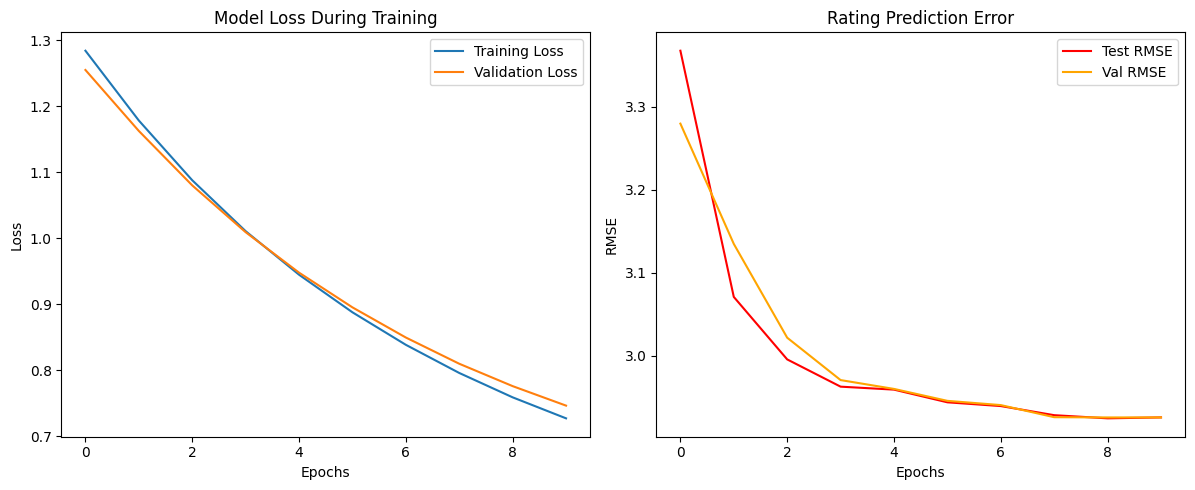

In [38]:
# Plot learning curves dengan validation metrics
plt.figure(figsize=(18, 5))  # Layout 3 subplot

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: RMSE
plt.subplot(1, 3, 2)
plt.plot(history['rmse'], label='Test RMSE', color='red')
plt.plot(history['val_rmse'], label='Val RMSE', color='orange')
plt.title('Rating Prediction Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# # Plot 3: HR dan NDCG
# plt.subplot(1, 3, 3)
# plt.plot(history['hr'], label='Test HR')
# plt.plot(history['ndcg'], label='Test NDCG')
# plt.title('Recommendation Metrics')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# plt.legend()


plt.tight_layout()
plt.show()

## **Test Model Performance and Comprehensive Evaluation**

In [40]:
# Load best model weights
# model.load_weights('dmf_best_model.h5')

# Evaluasi final & efek TopN
final_hr, final_ndcg, final_rmse = evaluate_model(model, test_ratings, test_negatives, topN)
print(f"Final metrics: HR = {final_hr:.4f}, NDCG = {final_ndcg:.4f}, RMSE = {final_rmse:.4f}")

# Evaluasi berbagai nilai TopN
topn_values = [5, 10, 15, 20]
results = []
for n in topn_values:
   hr, ndcg, rmse = evaluate_model(model, test_ratings, test_negatives, n)
   results.append([n, hr, ndcg, rmse])

# Tampilkan hasil
results_df = pd.DataFrame(results, columns=['TopN', 'HR', 'NDCG', 'RMSE'])
print("\nPerformance at different TopN values:")
print(results_df)

# Visualisasi
plt.subplot(1, 3, 1)
plt.plot(results_df['TopN'], results_df['HR'], marker='o')
plt.title('Hit Ratio at different TopN values')
plt.xlabel('TopN'); plt.ylabel('Hit Ratio'); plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(results_df['TopN'], results_df['NDCG'], marker='o', color='orange')
plt.title('NDCG at different TopN values')
plt.xlabel('TopN'); plt.ylabel('NDCG'); plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(results_df['TopN'], results_df['RMSE'], marker='o', color='red')
plt.title('RMSE at different TopN values')
plt.xlabel('TopN'); plt.ylabel('RMSE'); plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# ## Comprehensive Evaluation with Additional Metrics
# print("\n## Comprehensive Model Evaluation")
# print("Evaluating DMF with additional metrics...")

# # Evaluate model with threshold 0.7 (standard threshold)
# threshold = 0.7
# dmf_eval = evaluate_dmf_detailed(
#     model=model,
#     test_ratings=test_ratings,
#     test_negatives=test_negatives,
#     topN=topN,
#     threshold=threshold
# )
# print_dmf_evaluation_results(dmf_eval, topN)

# # Simple visualization of key metrics
# plt.figure(figsize=(12, 5))

# # Plot 1: Key metrics overview
# plt.subplot(1, 2, 1)
# metrics_names = ['HR', 'NDCG', 'RMSE']  # Removed MAE
# metrics_values = [dmf_eval['hr'], dmf_eval['ndcg'], dmf_eval['rmse']]  # Removed MAE value
# colors = ['blue', 'green', 'red']  # Removed orange for MAE

# plt.bar(metrics_names, metrics_values, color=colors)
# plt.title('DMF Performance - Key Metrics')
# plt.ylabel('Score')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Plot 2: Confusion matrix
# plt.subplot(1, 2, 2)
# cm = dmf_eval['confusion_matrix']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title(f'Confusion Matrix (Threshold={threshold})')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')

# plt.tight_layout()
# plt.savefig('dmf_evaluation_summary.png')
# plt.show()

## **Get Recommendations**

## **Predict 1**

In [41]:
# Cek user ID yang tersedia
print("Daftar User ID yang tersedia:")
# Konversi ke int biasa untuk menghilangkan format np.int64
sample_users = [int(uid) for uid in list(user_to_index.keys())[:10]]
print(f"Contoh Beberapa User ID: {sample_users}")

# Menggunakan user ID spesifik
user_id = 1  # Menggunakan user ID langsung
print(f"Menggunakan User ID: {user_id}")

Daftar User ID yang tersedia:
Contoh Beberapa User ID: [1, 4, 9, 20, 23, 37, 47, 48, 53, 66]
Menggunakan User ID: 1


In [42]:
def get_recommendations_dmf(model, user_id, df_anime, df_score, user_to_index, index_to_anime, top_n=10):
    """
    Memberikan rekomendasi anime untuk user berdasarkan model DMF dengan perbandingan rating asli.
    """
    if user_id not in user_to_index:
        print(f"User ID {user_id} tidak ditemukan dalam dataset")
        return None
    
    # Dapatkan user index
    user_idx = user_to_index[user_id]
    
    # Siapkan data untuk prediksi
    all_items = np.arange(len(index_to_anime))
    user_input = np.full(len(all_items), user_idx)
    
    # Prediksi skor untuk semua anime
    print(f"Memprediksi rating untuk semua anime untuk user ID {user_id}...")
    predictions = model.predict(
        [user_input, all_items],
        batch_size=4096,
        verbose=1
    ).flatten()
    
    # Ambil data rating yang diberikan oleh user
    user_ratings = df_score[df_score['user_id'] == user_id]
    print(f"User ini telah menilai {len(user_ratings)} anime")
    
    # Scale predictions to full range 1-10
    # Cari min dan max nilai prediksi untuk normalisasi yang lebih baik
    min_pred = np.min(predictions)
    max_pred = np.max(predictions)
    
    # Normalisasi ke range [0,1] dahulu kemudian ke [1,10]
    if max_pred > min_pred:  # Hindari division by zero
        normalized_preds = (predictions - min_pred) / (max_pred - min_pred)
        scaled_preds = 1.0 + (normalized_preds * 9.0)  # Scale to [1,10]
    else:
        scaled_preds = np.full_like(predictions, 5.0)  # Default ke nilai tengah
    
    # Dapatkan anime_ids yang telah dinilai
    rated_anime_ids = user_ratings['anime_id'].tolist()
    
    # Konversi indeks prediksi ke anime_id dengan skala [1,10]
    anime_id_to_score = {index_to_anime[i]: score for i, score in zip(all_items, scaled_preds)}
    
    # Buat DataFrame untuk semua prediksi
    all_predictions = pd.DataFrame({
        'anime_id': list(anime_id_to_score.keys()),
        'Rating_Prediction': list(anime_id_to_score.values())
    })
    
    # Gabungkan dengan informasi anime
    all_predictions = all_predictions.merge(
        df_anime[['anime_id', 'Name', 'Genres', 'Score']], 
        on='anime_id'
    )
    
    # Pisahkan antara anime yang sudah dinilai dan belum dinilai
    rated_predictions = all_predictions[all_predictions['anime_id'].isin(rated_anime_ids)].copy()
    unrated_predictions = all_predictions[~all_predictions['anime_id'].isin(rated_anime_ids)].copy()
    
    # Jika ada anime yang sudah dinilai
    if len(rated_predictions) > 0:
        # Gabungkan dengan rating asli
        rated_predictions = rated_predictions.merge(
            user_ratings[['anime_id', 'rating']], 
            on='anime_id'
        ).rename(columns={'rating': 'User_Rating'})
        
        # Urutkan berdasarkan prediksi tertinggi
        rated_predictions = rated_predictions.sort_values('Rating_Prediction', ascending=False)
    
    # Urutkan dan ambil top-n rekomendasi untuk anime yang belum dinilai
    unrated_predictions = unrated_predictions.sort_values('Rating_Prediction', ascending=False).head(top_n)
    
    # Return both dataframes
    return rated_predictions, unrated_predictions

In [43]:
# Contoh penggunaan
user_id = 1

# Dapatkan rekomendasi
rated_predictions, unrated_predictions = get_recommendations_dmf(
    model=model,  # Model DMF yang sudah dilatih
    user_id=user_id,
    df_anime=df_anime,
    df_score=df_score,
    user_to_index=user_to_index,
    index_to_anime=index_to_anime,
    top_n=10
)

# Tampilkan hasil hanya untuk anime yang sudah dinilai
if len(rated_predictions) > 0:
    print(f"\nTop 10 Anime yang Sudah Dinilai oleh User ID: {user_id}")
    display(rated_predictions[['Name', 'Genres', 'Score', 'Rating_Prediction', 'User_Rating']].head(10))
    
    # Hitung error
    error = rated_predictions['Rating_Prediction'] - rated_predictions['User_Rating']
    print(f"\nEvaluasi untuk {len(rated_predictions)} anime yang dinilai:")
    print(f"RMSE: {np.sqrt(np.mean(error**2)):.4f}")
    print(f"MAE: {np.mean(np.abs(error)):.4f}")
else:
    print(f"\nUser ID {user_id} belum menilai anime apapun dalam dataset.")

Memprediksi rating untuk semua anime untuk user ID 1...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
User ini telah menilai 262 anime

Top 10 Anime yang Sudah Dinilai oleh User ID: 1


,Name,Genres,Score,Rating_Prediction,User_Rating
213,Death Note,"Supernatural, Suspense",8.62,10.000000,9
48,Fullmetal Alchemist,"Action, Adventure, Award Winning, Drama, Fantasy",8.11,9.710938,9
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,9.421875,10
111,Elfen Lied,"Action, Drama, Horror, Romance, Supernatural",7.48,8.773438,8
194,Suzumiya Haruhi no Yuuutsu,"Award Winning, Comedy, Mystery, Sci-Fi",7.83,8.703125,10
136,Bleach,"Action, Adventure, Fantasy",7.92,8.570312,9
217,Code Geass: Hangyaku no Lelouch,"Action, Award Winning, Drama, Sci-Fi",8.70,8.484375,8
67,Mononoke Hime,"Action, Adventure, Award Winning, Fantasy",8.67,8.351562,9
91,Sen to Chihiro no Kamikakushi,"Adventure, Award Winning, Supernatural",8.78,8.234375,10
242,Code Geass: Hangyaku no Lelouch R2,"Action, Award Winning, Drama, Sci-Fi",8.91,8.132812,6



Evaluasi untuk 262 anime yang dinilai:
RMSE: 3.6224
MAE: 3.2992


In [44]:
# Filter hasil rekomendasi berdasarkan genre tertentu
genre_filter = "Action"  # Misalnya kita tertarik dengan anime genre Action

# Dapatkan semua rekomendasi untuk user terlebih dahulu
rated_predictions, _ = get_recommendations_dmf(
    model=model,  # Model DMF yang sudah dilatih
    user_id=user_id,
    df_anime=df_anime,
    df_score=df_score,
    user_to_index=user_to_index,
    index_to_anime=index_to_anime,
    top_n=10
)

# Filter berdasarkan genre dan hanya yang sudah diberi rating
dmf_genre_rated = rated_predictions[rated_predictions['Genres'].str.contains(genre_filter, na=False)]

# Urutkan berdasarkan prediksi rating tertinggi
dmf_genre_rated = dmf_genre_rated.sort_values(by='Rating_Prediction', ascending=False)

# Tampilkan hasil yang sudah dinilai oleh user
if len(dmf_genre_rated) > 0:
    print(f"\nTop 10 Anime Bergenre {genre_filter} yang Sudah Dinilai oleh User ID: {user_id}")
    display(dmf_genre_rated[['Name', 'Genres', 'Score', 'Rating_Prediction', 'User_Rating']].head(10))
    
    # Hitung error untuk anime bergenre ini yang sudah dinilai
    rmse_genre = np.sqrt(np.mean((dmf_genre_rated['Rating_Prediction'] - dmf_genre_rated['User_Rating'])**2))
    mae_genre = np.mean(np.abs(dmf_genre_rated['Rating_Prediction'] - dmf_genre_rated['User_Rating']))
    print(f"RMSE: {rmse_genre:.4f}, MAE: {mae_genre:.4f}")
else:
    print(f"\nUser belum menilai anime dengan genre {genre_filter}")

Memprediksi rating untuk semua anime untuk user ID 1...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
User ini telah menilai 262 anime

Top 10 Anime Bergenre Action yang Sudah Dinilai oleh User ID: 1


,Name,Genres,Score,Rating_Prediction,User_Rating
48,Fullmetal Alchemist,"Action, Adventure, Award Winning, Drama, Fantasy",8.11,9.710938,9
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,9.421875,10
111,Elfen Lied,"Action, Drama, Horror, Romance, Supernatural",7.48,8.773438,8
136,Bleach,"Action, Adventure, Fantasy",7.92,8.570312,9
217,Code Geass: Hangyaku no Lelouch,"Action, Award Winning, Drama, Sci-Fi",8.70,8.484375,8
67,Mononoke Hime,"Action, Adventure, Award Winning, Fantasy",8.67,8.351562,9
242,Code Geass: Hangyaku no Lelouch R2,"Action, Award Winning, Drama, Sci-Fi",8.91,8.132812,6
15,Neon Genesis Evangelion,"Action, Avant Garde, Award Winning, Drama, Sci...",8.35,8.070312,10
97,Samurai Champloo,"Action, Adventure, Comedy",8.51,8.031250,9
225,Claymore,"Action, Adventure, Fantasy",7.74,7.851562,8


RMSE: 3.4261, MAE: 3.0052


## **Save and Load Model**

In [31]:
# Save model
model.save('dmf.h5')
print("Model saved as 'dmf.h5'")

# Test loading the model and making predictions
try:
    loaded_model = tf.keras.models.load_model('dmf.h5')
    print("Successfully loaded model")
    
    # Generate recommendations using loaded model
    print("Generating recommendations with loaded model...")
    recommendations = get_recommendations(loaded_model, sample_user_id, top_n=5)
    print("\nTop 5 Recommendations from loaded model:")
    for i, rec in enumerate(recommendations):
        print(f"{i+1}. {rec['name']} (Predicted Score: {rec['score']:.4f})")
except Exception as e:
    print(f"Error loading model: {e}")

NameError: name 'model' is not defined

In [32]:
# Save model weights (bukan model utuh)
model.save_weights('dmf.weights.h5')  # Perbaikan: tambahkan .weights.h5 sebagai akhiran
print("Model weights saved as 'dmf.weights.h5'")

# Fungsi untuk membuat ulang model dan memuat weights
def load_dmf_model(weights_path):
    # Buat model DMF baru
    dmf_new = DMF(num_users=num_users,
                 num_items=num_animes,
                 user_layers=user_layers,
                 item_layers=item_layers,
                 lr=learning_rate,
                 train_matrix=None)  # Tidak perlu train_matrix untuk prediksi
                
    # Dapatkan model
    new_model = dmf_new.get_model()
    
    # Load weights
    new_model.load_weights(weights_path)
    
    return new_model

NameError: name 'model' is not defined